In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle, Patch
from matplotlib.colors import Normalize
from pathlib import Path

In [8]:
INPUT_CSV = Path('/Users/carlos/Desktop/evollm/data/YAP1_all_possible_scores_with_epi.csv')
PDB_PATH  = Path('/Users/carlos/Desktop/evollm/pdbs/yap1_1k9r.pdb')
OUT_DIR   = Path('/Users/carlos/Desktop/evollm/paper_figs')
OUT_DIR.mkdir(parents=True, exist_ok=True)

# MIN_PDB_RES corresponds to the residue index in the PDB that matches the first residue in INPUT_CSV
# For YAP1 is 9
# For TEM1 is 23
# for RRM2 is 0
MIN_PDB_RES = 9
# LABEL_OFFSET adds this offset value to residue indeces in figures, this match numbering reported in literature
# For YAP1 is 169
# For TEM1 is 2
# For RRM2 is 125
LABEL_OFFSET = 169  

In [3]:
# Utilities
def load_filtered_csv(path, min_res=MIN_PDB_RES):
    df = pd.read_csv(path)
    df = df[(df['Position 1'] >= min_res) & (df['Position 2'] >= min_res)].copy()
    return df

def build_symmetric_matrix(df, col):
    mat = df.pivot_table(index='Position 1', columns='Position 2', values=col, aggfunc='mean')
    pos = sorted(set(df['Position 1']) | set(df['Position 2']))
    mat = mat.reindex(index=pos, columns=pos)
    mat = mat.combine_first(mat.T)
    return mat

def load_ca_coords(pdb_path):
    ca = {}
    with open(pdb_path, 'r') as fh:
        for L in fh:
            if L.startswith('ATOM') and L[12:16].strip() == 'CA':
                resid = int(L[22:26])
                ca[resid] = np.array([float(L[30:38]), float(L[38:46]), float(L[46:54])])
    return ca

def build_distance_matrix(ca_coords):
    positions = sorted(ca_coords.keys())
    coords = np.vstack([ca_coords[p] for p in positions])
    d = np.linalg.norm(coords[:,None,:] - coords[None,:,:], axis=-1)
    return pd.DataFrame(d, index=positions, columns=positions)

In [4]:
# Plot: epistasis heatmaps and contact map
def plot_heatmap_and_contact(epi_mat, dist_mat, title, out_prefix=None,
                             figsize=(14,6), cmap_epi='RdBu_r', cmap_dist='RdBu',
                             nticks=10, label_offset=0, separate_figures=False,
                             show_cbar_epi=True, show_cbar_dist=True, contact_start_res=None):
    vals = np.abs(epi_mat.values)
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals))
    if vmax < vmin:
        vmin, vmax = vmax, vmin

    N = epi_mat.shape[0]
    if dist_mat.shape[0] < N or dist_mat.shape[1] < N:
        raise ValueError("dist_mat is smaller than epi_mat; cannot align.")
    dist_trim = dist_mat.iloc[:N, :N]

    tick_idx = np.linspace(0, N-1, min(nticks, N), dtype=int)
    tick_labels = [str(int(epi_mat.index[i] + label_offset)) for i in tick_idx]
    epi_abs = np.abs(epi_mat.values)

    if separate_figures:
        fig, ax = plt.subplots(figsize=figsize)
        im = ax.imshow(epi_abs, aspect='equal', cmap=cmap_epi)
        ax.set_xticks(tick_idx); ax.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax.set_yticks(tick_idx); ax.set_yticklabels(tick_labels)
        ax.set_xlabel('Position 2'); ax.set_ylabel('Position 1')
        if show_cbar_epi: fig.colorbar(im, ax=ax, label='Epistasis')
        if out_prefix: fig.savefig(f"{out_prefix}_epi.pdf", dpi=300)
        plt.show()

        fig2, ax2 = plt.subplots(figsize=figsize)
        im2 = ax2.imshow(dist_trim.values, aspect='equal', cmap=cmap_dist)
        ax2.set_xticks(tick_idx); ax2.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax2.set_yticks(tick_idx); ax2.set_yticklabels(tick_labels)
        ax2.set_xlabel('Position 2'); ax2.set_ylabel('Position 1')
        if show_cbar_dist: fig2.colorbar(im2, ax=ax2, label='Distance (Å)')
        if out_prefix: fig2.savefig(f"{out_prefix}_contact.pdf", dpi=300)
        plt.show()
    else:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=figsize)
        im1 = ax1.imshow(epi_abs, aspect='equal', cmap=cmap_epi)
        im2 = ax2.imshow(dist_trim.values, aspect='equal', cmap=cmap_dist)
        ax1.set_xticks(tick_idx); ax1.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax1.set_yticks(tick_idx); ax1.set_yticklabels(tick_labels)
        ax2.set_xticks(tick_idx); ax2.set_xticklabels(tick_labels, rotation=45, ha='right')
        ax2.set_yticks(tick_idx); ax2.set_yticklabels(tick_labels)
        ax1.set_xlabel('Position 2'); ax1.set_ylabel('Position 1')
        ax2.set_xlabel('Position 2'); ax2.set_ylabel('Position 1')
        if show_cbar_epi: fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Epistasis')
        if show_cbar_dist: fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='Distance (Å)')
        plt.tight_layout()
        if out_prefix: fig.savefig(f"{out_prefix}.pdf", dpi=300)
        plt.show()

# Plot: circular epistasis map
def plot_circular_independent(
    epi_mat,
    rss_threshold=None,
    top_n_nodes=None,
    top_n_edges=None,
    group_residues=None,
    group_colors=None,
    group_names=None,
    node_size_min=0.05, node_size_max=0.20,
    font_size_min=8, font_size_max=16,
    cmap_name='Greys', cmap_min_intensity=0.2,
    edge_width=1.0,
    node_edge_width=1.0,
    rad=-0.3,
    rad_consec=None,
    figsize=(8,8),
    output_prefix='circ_epi',
    legend_loc='upper right',
    show_labels=True,
    show_only_group_labels=False,
    highlight_group_edges=False,
    highlight_edge_color='blue',
    label_offset=0
):

    if rad_consec is None:
        rad_consec = rad

    group_residues = group_residues or []
    group_colors = group_colors or []
    group_names = group_names or []
    group_nodes = {n for grp in group_residues for n in grp}

    # melt upper triangle
    long = (
        epi_mat
        .rename_axis(index='Position 1', columns='Position 2')
        .stack().reset_index(name='epi')
    )
    long = long[long['Position 1'] < long['Position 2']].copy()

    # filters
    if rss_threshold is not None:
        long = long[long['epi'].abs() > rss_threshold]

    if top_n_nodes is not None:
        sq = pd.concat([
            long[['Position 1','epi']].rename(columns={'Position 1':'res'}),
            long[['Position 2','epi']].rename(columns={'Position 2':'res'})
        ], ignore_index=True)
        rss = sq.groupby('res')['epi'].agg(lambda arr: np.sqrt((arr**2).sum()))
        topn = set(rss.nlargest(top_n_nodes).index)
        long = long[long['Position 1'].isin(topn) & long['Position 2'].isin(topn)]

    if top_n_edges is not None:
        long = long.reindex(long['epi'].abs().sort_values(ascending=False).index).head(top_n_edges)

    edges = long.reset_index(drop=True)
    if edges.empty:
        print("[circular_independent] no edges selected — nothing to draw.")
        return

    nodes = sorted(set(edges['Position 1']).union(edges['Position 2']))
    if len(nodes) == 0:
        print("[circular_independent] no nodes to draw.")
        return

    N = len(nodes)
    order = {n:i for i,n in enumerate(nodes)}

    # per-node RSS
    tot = pd.Series(0.0, index=nodes, dtype=float)
    for _, r in edges.iterrows():
        tot.at[r['Position 1']] += float(r['epi'])**2
        tot.at[r['Position 2']] += float(r['epi'])**2
    rss_vals = np.sqrt(tot.values.astype(float))

    # scale helper
    def scale(vals, a, b):
        vals = np.asarray(vals, dtype=float)
        mn, mx = vals.min(), vals.max()
        if mx <= mn:
            return np.full_like(vals, (a + b) / 2.0, dtype=float)
        return a + (vals - mn) / (mx - mn) * (b - a)

    rs = scale(rss_vals, node_size_min, node_size_max)
    fs = scale(rss_vals, font_size_min, font_size_max)

    # circle positions
    ang = {n: 2*np.pi*i/N for i,n in enumerate(nodes)}
    pos = {n:(np.cos(a), np.sin(a)) for n,a in ang.items()}

    # color mapping
    edge_vmax = float(edges['epi'].abs().max()) if not edges.empty else 0.0
    edge_vmax = max(edge_vmax, 1e-9)
    cmap = mpl.colormaps[cmap_name]
    norm = Normalize(vmin=0.0, vmax=edge_vmax)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect('equal'); ax.axis('off')

    # draw edges
    for _, r in edges.iterrows():
        i = int(r['Position 1']); j = int(r['Position 2']); e = float(r['epi'])
        if i not in pos or j not in pos:
            continue
        ri, rj = order[i], order[j]
        cr = rad_consec if abs(ri-rj)==1 or {i,j}=={nodes[0],nodes[-1]} else rad
        if highlight_group_edges and (i in group_nodes and j in group_nodes):
            col = highlight_edge_color
        else:
            t = norm(abs(e))
            col = cmap(cmap_min_intensity + t*(1-cmap_min_intensity))
        ax.add_patch(FancyArrowPatch(
            pos[i], pos[j],
            connectionstyle=f"arc3,rad={cr}",
            arrowstyle='-',
            linewidth=edge_width,
            color=col,
            zorder=1
        ))

    # draw nodes + labels
    for idx, n in enumerate(nodes):
        x, y = pos[n]
        fc = 'white'
        if group_residues and group_colors:
            for grp, c in zip(group_residues, group_colors):
                if n in grp:
                    fc = c
                    break
        ax.add_patch(Circle(
            (x, y), radius=rs[idx], facecolor=fc, edgecolor='black',
            linewidth=node_edge_width, zorder=2
        ))
        if show_labels and (not show_only_group_labels or n in group_nodes):
            ax.text(x, y, str(int(n + label_offset)), ha='center', va='center', fontsize=fs[idx], zorder=3)

    # group legend
    if group_names and group_colors:
        pairs = list(zip(group_colors, group_names))
        handles = [Patch(facecolor=c, edgecolor='black', label=nm) for c,nm in pairs]
        ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(.9,1.0), frameon=False)  

    lim = 1 + node_size_max + 0.1
    ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
    plt.tight_layout()
    if output_prefix:
        out_file = f"{output_prefix}_independent.pdf"
        try:
            fig.savefig(out_file, dpi=300)
            print(f"Saved {out_file}")
        except Exception as ex:
            print(f"Warning: failed to save {out_file}: {ex}")
    plt.show()

In [5]:
# Create epistasis matrices
df = load_filtered_csv(INPUT_CSV)
epi_trans = build_symmetric_matrix(df, 'transformed_epistasis')
epi_untrans = build_symmetric_matrix(df, 'untransformed_epistasis')

# Get C-alpha coordinates
ca_coords = load_ca_coords(PDB_PATH)
dist_mat = build_distance_matrix(ca_coords)

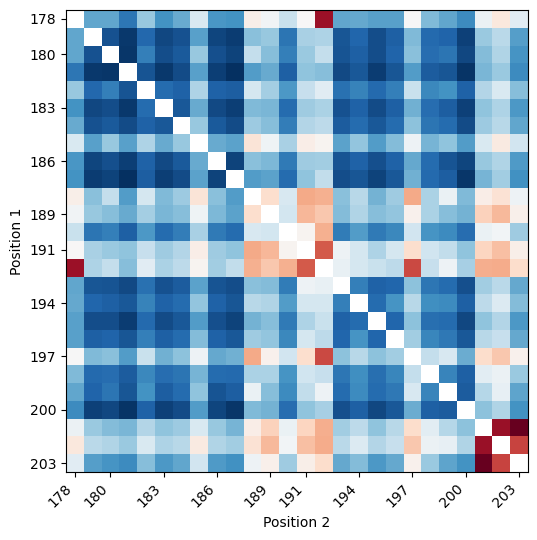

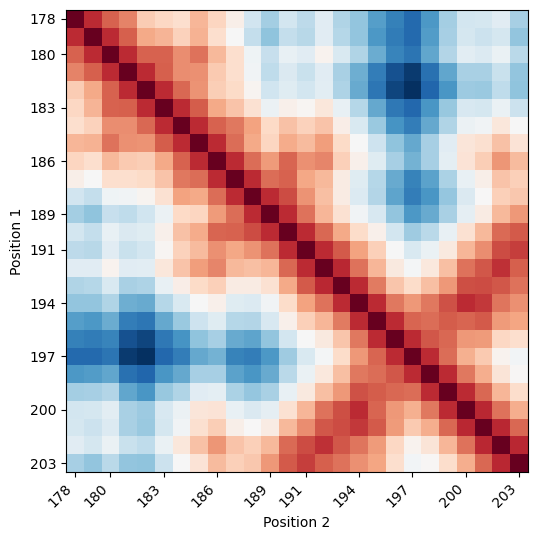

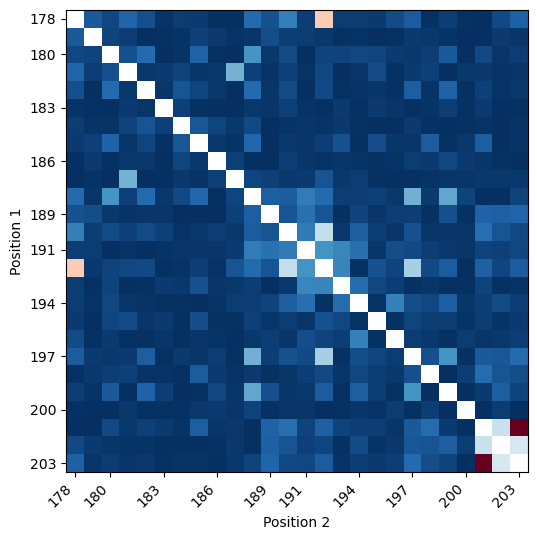

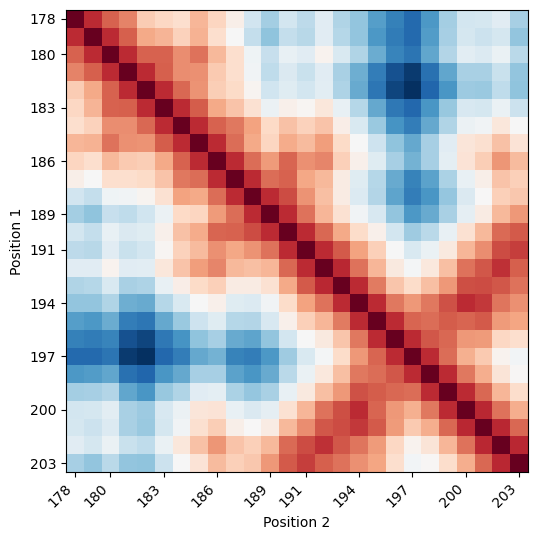

In [6]:
# Plot epistasis heatmaps and contact map
plot_heatmap_and_contact(epi_trans, dist_mat,
                         title='',
                         out_prefix=str(OUT_DIR / 'yap1_transformed'),
                         label_offset=LABEL_OFFSET, separate_figures=True,
                         show_cbar_epi=False, show_cbar_dist=False)

plot_heatmap_and_contact(epi_untrans, dist_mat,
                         title='',
                         out_prefix=str(OUT_DIR / 'yap1_untransformed'),
                         label_offset=LABEL_OFFSET, separate_figures=True,
                         show_cbar_epi=False, show_cbar_dist=False)

Saved /Users/carlos/Desktop/evollm/testt/yap1_transformed_independent.pdf


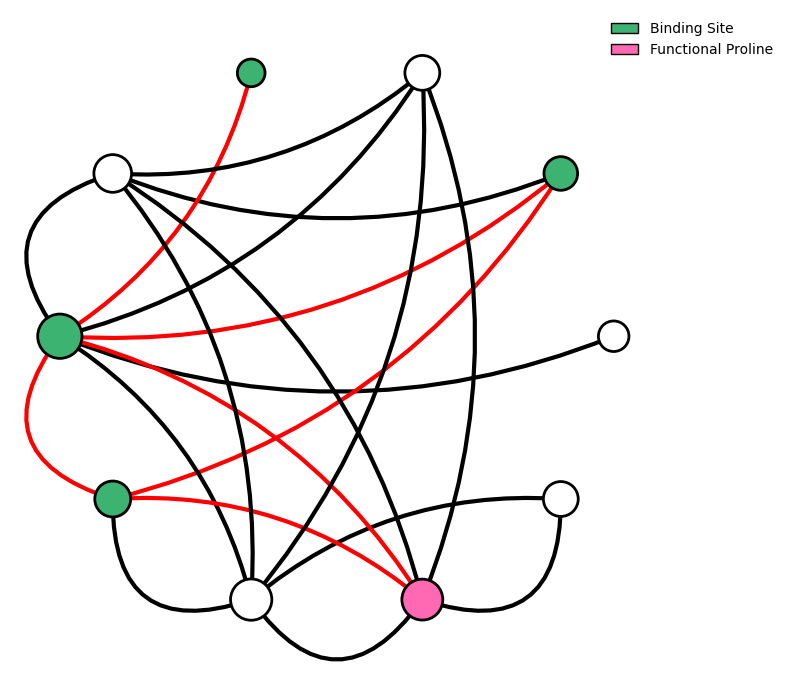

Saved /Users/carlos/Desktop/evollm/testt/yap1_untransformed_independent.pdf


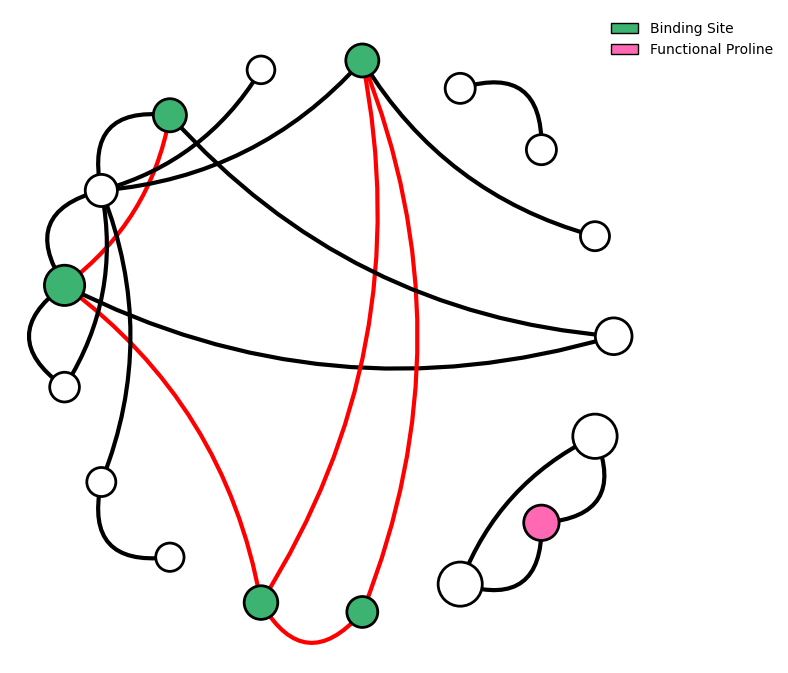

In [7]:
# Plot circular epistasis graphs
plot_circular_independent(
    epi_trans,
    top_n_edges=20,
    group_residues=[[19,21,23,26,28,30],[33]],
    group_colors=['#3CB371','#FF69B4'],
    group_names=['Binding Site','Functional Proline'],
    show_only_group_labels=False,
    show_labels=False,
    highlight_group_edges=True,
    highlight_edge_color='#FF0000',
    rad=-0.2,
    rad_consec=0.7,
    node_size_min=0.05,
    node_size_max=0.08,
    font_size_min=10,
    font_size_max=17,
    edge_width=3,
    label_offset=LABEL_OFFSET,
    cmap_name='Greys',
    cmap_min_intensity=1,
    node_edge_width=2,
    output_prefix=str(OUT_DIR / 'yap1_transformed')
)

plot_circular_independent(
    epi_untrans,
    top_n_edges=20,
    group_residues=[[19,21,23,26,28,30],[33]],
    group_colors=['#3CB371','#FF69B4'],
    group_names=['Binding Site','Functional Proline'],
    show_only_group_labels=False,
    show_labels=False,
    highlight_group_edges=True,
    highlight_edge_color='#FF0000',
    rad=-0.2,
    rad_consec=0.7,
    node_size_min=0.05,
    node_size_max=0.08,
    font_size_min=10,
    font_size_max=17,
    edge_width=3,
    label_offset=LABEL_OFFSET,
    cmap_name='Greys',
    cmap_min_intensity=1,
    node_edge_width=2,
    output_prefix=str(OUT_DIR / 'yap1_untransformed')
)